# Setup and Data Loading

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("Global Terrorism Analysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/01 21:47:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/01 21:47:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [23]:
# Load the dataset
df = spark.read.csv("globalterrorismdb_0718dist.csv", header=True, inferSchema=True)

# View schema
df.printSchema()

root
 |-- eventid: long (nullable = true)
 |-- iyear: integer (nullable = true)
 |-- imonth: integer (nullable = true)
 |-- iday: integer (nullable = true)
 |-- approxdate: string (nullable = true)
 |-- extended: integer (nullable = true)
 |-- resolution: string (nullable = true)
 |-- country: integer (nullable = true)
 |-- country_txt: string (nullable = true)
 |-- region: integer (nullable = true)
 |-- region_txt: string (nullable = true)
 |-- provstate: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- specificity: integer (nullable = true)
 |-- vicinity: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- crit1: string (nullable = true)
 |-- crit2: string (nullable = true)
 |-- crit3: string (nullable = true)
 |-- doubtterr: string (nullable = true)
 |-- alternative: string (nullable = true)
 |-- alternative_txt: string (nullable

In [24]:
# View the shape of the dataset
rows = df.count()
cols = len(df.columns)
print("Dataset has {rows} rows and {cols} columns.\n")

Dataset has {rows} rows and {cols} columns.



In [25]:
# sample_df = df.limit(100000)
# sample_pandas_df = sample_df.toPandas

# import sweetviz as sv
# report = sv.analyze(pandas_df)
# report.show_html("sweetviz_report.html")

# Visualizations

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import plotly.express as px
from wordcloud import WordCloud

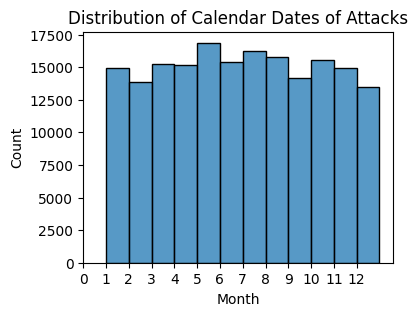

In [42]:
# Convert PySpark DataFrame to Pandas
df_pd = df.select("imonth","iday").toPandas()

# Plot the distribution of attacks in each month
plt.figure(figsize=(4,3))
sns.histplot(data=df_pd, x='imonth',bins=list(range(1,14)))
plt.title("Distribution of Calendar Dates of Attacks")
plt.xlabel("Month")
plt.ylabel("Count")

# Set x-ticks at every integer
min_val = int(df_pd["imonth"].min())
max_val = int(df_pd["imonth"].max())
plt.xticks(range(min_val, max_val + 1))

plt.show()

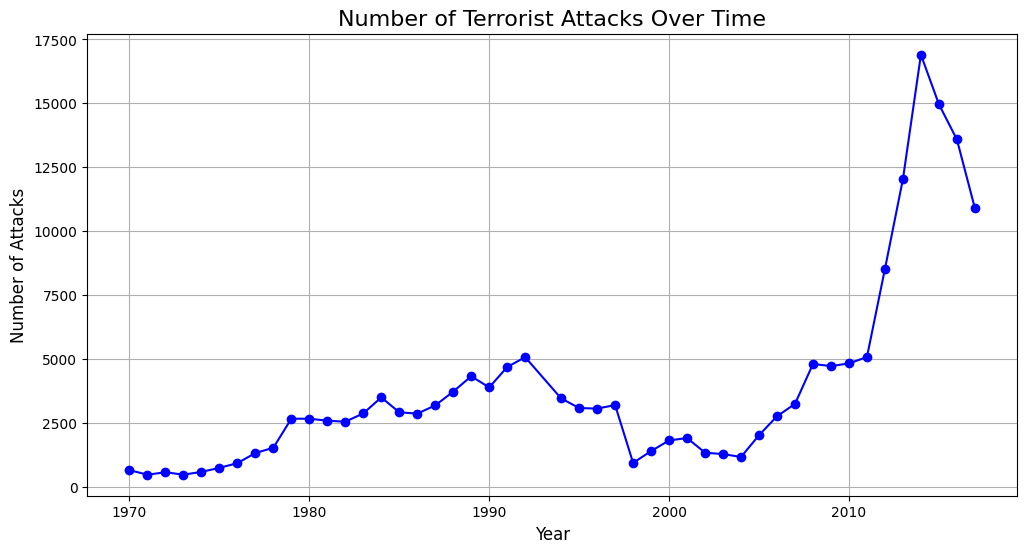

In [43]:
# Convert PySpark DataFrame to Pandas
df_pd = df.select("iyear").toPandas()

# Plot number of attacks per year
attacks_per_year = df_pd["iyear"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(attacks_per_year.index, attacks_per_year.values, marker='o', color='b')
plt.title("Number of Terrorist Attacks Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Attacks", fontsize=12)
plt.grid(True)
plt.show()

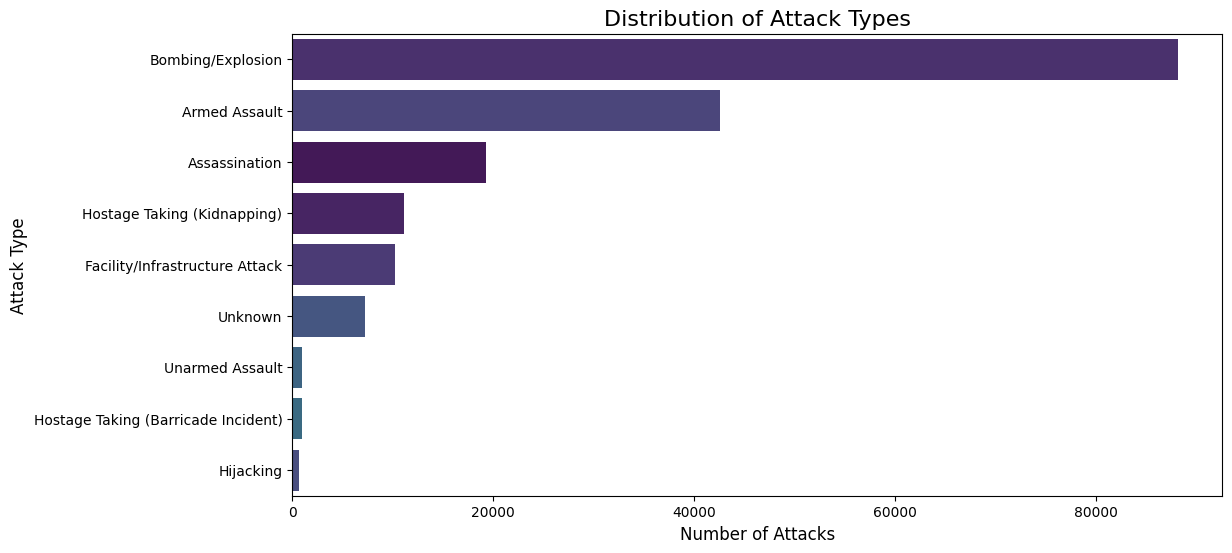

In [44]:
# Attack type distribution
df_attack_type = df.select("attacktype1_txt").toPandas()
plt.figure(figsize=(12, 6))
n_largest = 9
sns.countplot(data=df_attack_type, 
              y="attacktype1_txt", 
              order=df_attack_type['attacktype1_txt'].value_counts().nlargest(n_largest).index, 
              hue="attacktype1_txt",
              legend=False,
              palette="viridis")
plt.title("Distribution of Attack Types", fontsize=16)
plt.xlabel("Number of Attacks", fontsize=12)
plt.ylabel("Attack Type", fontsize=12)
plt.show()

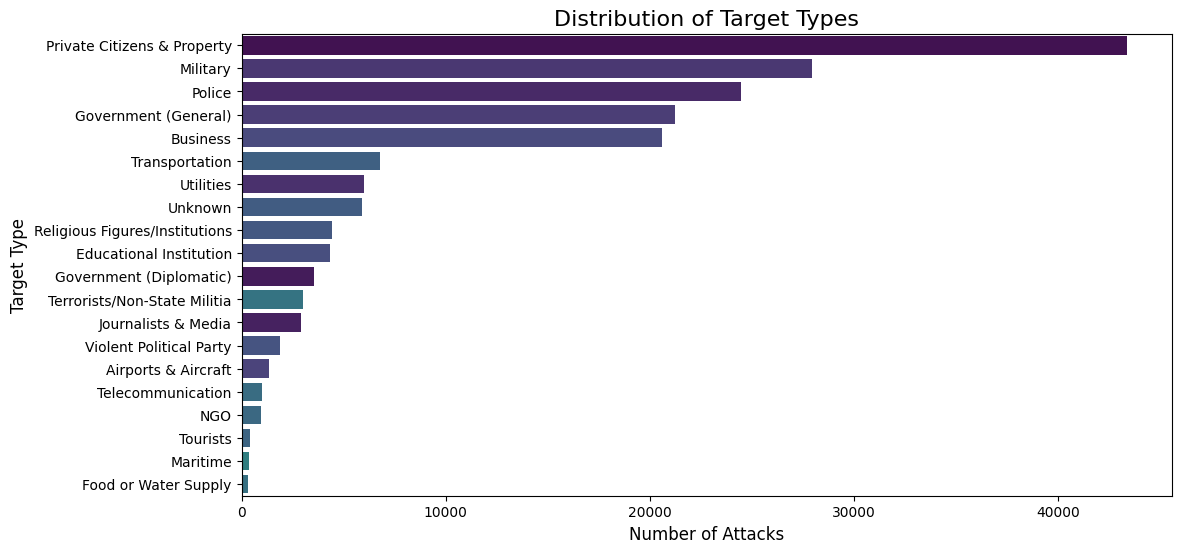

In [47]:
# Target type distribution
df_attack_type = df.select("targtype1_txt").toPandas()
plt.figure(figsize=(12, 6))
n_largest = 20
sns.countplot(data=df_attack_type, 
              y="targtype1_txt", 
              order=df_attack_type['targtype1_txt'].value_counts().nlargest(n_largest).index, 
              hue="targtype1_txt",
              legend=False,
              palette="viridis")
plt.title("Distribution of Target Types", fontsize=16)
plt.xlabel("Number of Attacks", fontsize=12)
plt.ylabel("Target Type", fontsize=12)
plt.show()

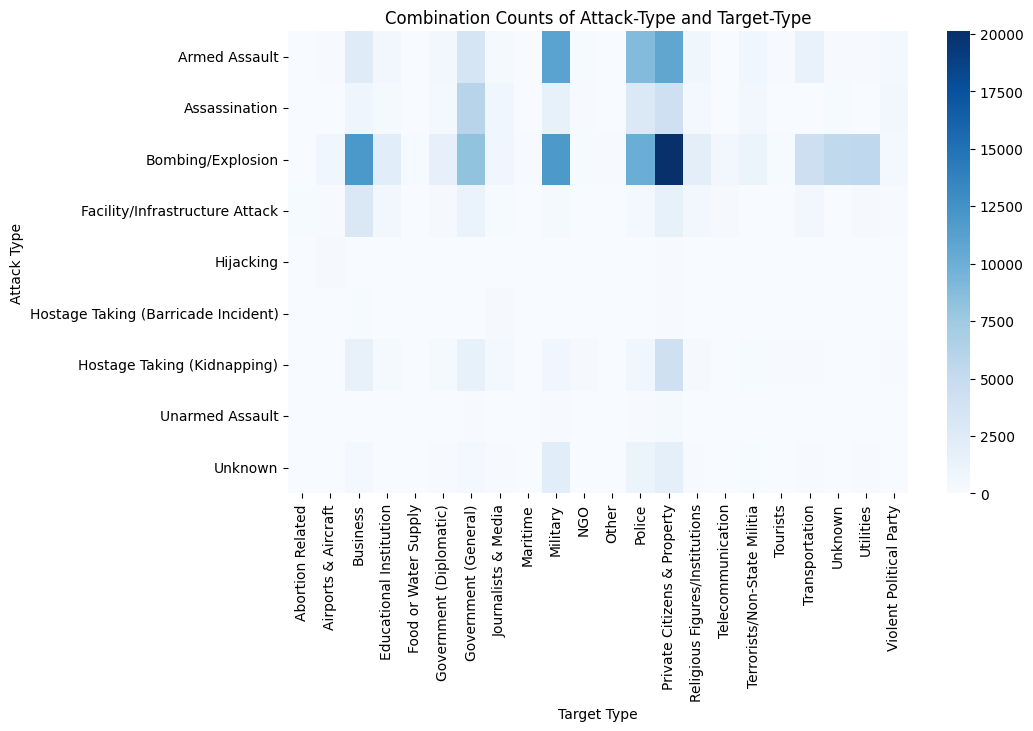

In [55]:
# Heatmap of Attack-Target Combinations 

# Convert PySpark DataFrame to Pandas
df_pd = df.select("attacktype1_txt", "targtype1_txt").toPandas()

# Filter to have only top 10 attack types and top 10 target types
# Step 1: Get the top 10 most frequent values of 'cat1'
top_10_attack = df_pd['attacktype1_txt'].value_counts().nlargest(10).index
top_10_target = df_pd['targtype'].value_counts().nlargest(10).index

# Step 2: Filter the DataFrame to keep only those rows
df_filtered = df_pd[df_pd['attacktype1_txt'].isin(top_10)]
# Step 3: Filter out rows where attacktype1_txt is '0'
df_filtered = df_filtered[df_filtered['attacktype1_txt'] != '0']

top_10 = df_p

# Create a crosstab (frequency table)
ct = pd.crosstab(df_filtered['attacktype1_txt'], df_filtered['targtype1_txt'])

# Plot as heatmap
plt.figure(figsize=(10,6))
sns.heatmap(ct, annot=False, fmt='d', cmap="Blues")
plt.title("Combination Counts of Attack-Type and Target-Type")
plt.xlabel("Target Type")
plt.ylabel("Attack Type")
plt.show()

In [ ]:
df_sample = df.select("latitude", "longitude", "attacktype1_txt").dropna().limit(500).collect()

# Create a map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add markers for attacks
for row in df_sample:
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        popup=row['attacktype1_txt'],
        color='red',
        fill=True
    ).add_to(m)

m.save("terrorism_map.html")

In [ ]:
df_attack_time = df.select("iyear", "attacktype1_txt").toPandas()
attack_time_series = df_attack_time.groupby(["iyear", "attacktype1_txt"]).size().reset_index(name="count")

# Line plot for top attack types
top_attack_types = df_attack_time["attacktype1_txt"].value_counts().head(5).index
plt.figure(figsize=(12, 6))
for attack in top_attack_types:
    subset = attack_time_series[attack_time_series["attacktype1_txt"] == attack]
    plt.plot(subset["iyear"], subset["count"], label=attack)

plt.title("Time-Series of Top Attack Methods", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Attacks", fontsize=12)
plt.legend(title="Attack Type")
plt.grid(True)
plt.show()

In [ ]:
df_region_casualties = df.groupBy("region_txt").agg({"nkill": "sum"}).toPandas()
df_region_casualties.sort_values(by="sum(nkill)", inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_region_casualties, x="sum(nkill)", y="region_txt", palette="magma")
plt.title("Total Fatalities by Region", fontsize=16)
plt.xlabel("Number of Fatalities", fontsize=12)
plt.ylabel("Region", fontsize=12)
plt.show()

In [ ]:
# Target type distribution
df_targets = df.select("targtype1_txt").toPandas()
n = 15
# Get top n counts
top_n = df_targets['targtype1_txt'].value_counts().nlargest(15).index
plt.figure(figsize=(12, 6))
sns.countplot(data=df_targets, y="targtype1_txt", order=top_n, palette="coolwarm")
plt.title("Top Target Types", fontsize=16)
plt.xlabel("Number of Attacks", fontsize=12)
plt.ylabel("Target Type", fontsize=12)
plt.show()

In [ ]:
# Group data by country
df_country = df.groupBy("country_txt").count().toPandas()
df_country.columns = ["country", "num_attacks"]

In [ ]:
geojson_path = 'https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json'

In [ ]:
# Create a choropleth map
m = folium.Map(location=[10, 20], zoom_start=2)
folium.Choropleth(
    geo_data=geojson_path,
    data=df_country,
    columns=["country", "num_attacks"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Attacks by Country"
).add_to(m)

m.save("choropleth_attacks_by_country.html")

In [ ]:
# Filter for non-null latitude and longitude
df_coords = df.select("latitude", "longitude").dropna().limit(5000).toPandas()

# Create a heatmap
m = folium.Map(location=[20, 0], zoom_start=2)
heat_data = [[row['latitude'], row['longitude']] for index, row in df_coords.iterrows()]
HeatMap(heat_data, radius=8).add_to(m)

m.save("heatmap_attacks.html")

In [ ]:
df_target = df.select("latitude", "longitude", "targtype1_txt").dropna().limit(1000).toPandas()

# Create a folium map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add markers for targets
for _, row in df_target.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=row["targtype1_txt"],
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

m.save("map_by_target_type.html")

In [ ]:
# Sample data
df_time = df.select("latitude", "longitude", "iyear", "attacktype1_txt").dropna().limit(5000).toPandas()

# Animated map
fig = px.scatter_geo(
    df_time,
    lat="latitude",
    lon="longitude",
    color="attacktype1_txt",
    animation_frame="iyear",
    title="Time-Series Animation of Terrorist Attacks",
    template="plotly",
    projection="natural earth"
)
fig.show()

In [ ]:
df_fatalities = df.groupBy("country_txt").agg({"nkill": "sum"}).toPandas()
df_fatalities.columns = ["country", "total_fatalities"]

# Create a choropleth
m = folium.Map(location=[10, 20], zoom_start=2)
folium.Choropleth(
    geo_data=geojson_path,
    data=df_fatalities,
    columns=["country", "total_fatalities"],
    key_on="feature.properties.name",
    fill_color="Reds",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Total Fatalities by Country"
).add_to(m)

m.save("choropleth_fatalities_by_country.html")

In [ ]:
# Extract attack type text and convert it to a Pandas DataFrame
attack_types = df.select("attacktype1_txt").toPandas()

# Combine all attack types into a single string
text = " ".join(attack_types["attacktype1_txt"].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(text)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Attack Types", fontsize=20)
plt.show()

# 

# Data Preparation

In [ ]:
# Select relevant columns for analysis
columns_to_keep = ["iyear", "imonth", "iday", "latitude", "longitude", "attacktype1", "attacktype1_txt",
                   "weaptype1", "weaptype1_txt", "nkill", "nwound", "success"]
df = df.select(columns_to_keep)

In [ ]:
# Handle missing values
df = df.na.fill({"nkill": 0, "nwound": 0, "latitude": 0, "longitude": 0})

In [ ]:
# Add derived columns (e.g., total casualties)
df = df.withColumn("casualties", col("nkill") + col("nwound"))

# Regression Analysis

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression

In [ ]:
# Encode attacktype1 and weaptype1 as numeric indices
attacktype_indexer = StringIndexer(inputCol="attacktype1", outputCol="attacktype1_index", handleInvalid="skip")
weaptype_indexer = StringIndexer(inputCol="weaptype1", outputCol="weaptype1_index", handleInvalid="skip")

In [ ]:
# Apply the indexers
df_indexed = attacktype_indexer.fit(df).transform(df)
df_indexed = weaptype_indexer.fit(df_indexed).transform(df_indexed)

In [ ]:
# Drop rows with null or skipped values after indexing
df_indexed = df_indexed.na.drop(subset=["attacktype1_index", "weaptype1_index", "casualties"])

In [ ]:
# Assemble features for regression
assembler = VectorAssembler(inputCols=["attacktype1_index", "weaptype1_index"], outputCol="features")
df_regression = assembler.transform(df_indexed).select("features", "casualties")

In [ ]:
# Split data for regression
train, test = df_regression.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Train Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="casualties")
lr_model = lr.fit(train)

In [ ]:
# Evaluate the model
predictions = lr_model.transform(test)
predictions.show()
print(f"R^2: {lr_model.summary.r2}")
print(f"RMSE: {lr_model.summary.rootMeanSquaredError}")

# Clustering

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler

In [ ]:
# Assemble features for clustering
assembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
df_clustering = assembler.transform(df)

In [ ]:
# Normalize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
df_scaled = scaler.fit(df_clustering).transform(df_clustering)

In [ ]:
# K-Means clustering
kmeans = KMeans(featuresCol="scaled_features", k=5, seed=42)
model = kmeans.fit(df_scaled)

# Predict clusters
clusters = model.transform(df_scaled)
clusters.select("latitude", "longitude", "prediction").show()

# Visualization

In [ ]:
# Collect predictions from the Linear Regression model
predictions = lr_model.transform(test)

# Convert to Pandas for plotting
predictions_pd = predictions.select("casualties", "prediction").toPandas()

# Plot the actual vs predicted casualties
plt.figure(figsize=(10,6))
plt.scatter(predictions_pd["casualties"], predictions_pd["prediction"], color='blue', alpha=0.5)
plt.plot([min(predictions_pd["casualties"]), max(predictions_pd["casualties"])],
         [min(predictions_pd["casualties"]), max(predictions_pd["casualties"])], color='red', linestyle='--')
plt.title('Predicted vs Actual Casualties (Linear Regression)')
plt.xlabel('Actual Casualties')
plt.ylabel('Predicted Casualties')
plt.show()

In [ ]:
# Compute residuals
predictions_pd['residuals'] = predictions_pd['casualties'] - predictions_pd['prediction']

# Plot residuals
plt.figure(figsize=(10,6))
plt.scatter(predictions_pd["prediction"], predictions_pd["residuals"], color='green', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals Plot (Linear Regression)')
plt.xlabel('Predicted Casualties')
plt.ylabel('Residuals')
plt.show()

In [ ]:
# Convert cluster predictions and geospatial data to Pandas for plotting
clusters_pd = clusters.select("latitude", "longitude", "prediction").toPandas()

# Plot clusters
plt.figure(figsize=(12,8))
plt.scatter(clusters_pd['longitude'], clusters_pd['latitude'], c=clusters_pd['prediction'], cmap='viridis', alpha=0.5)
plt.title('Terrorist Activity Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster ID')
plt.show()

In [ ]:
# Stop the Spark session
spark.stop()